In [1]:
from numpy.random import seed
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import torch
import torchvision
import torch.nn.functional as F

from composer.models import ComposerModel
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision import transforms, datasets

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import time
import torchmetrics

import torch.optim as optim
from composer import Trainer
import composer
from composer.algorithms import BlurPool
from composer.loggers import InMemoryLogger

import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
from torchvision.transforms.functional import InterpolationMode

from torchvision.models.inception import InceptionOutputs
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics


2023-08-29 06:10:40.474126: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 06:10:40.526332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 06:10:41.363689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
base_dir='./data/ham10000'

In [3]:
def requirementsForModelTraining(model):
    blurpool = BlurPool(
    replace_convs=True, # Blur before convs
    replace_maxpools=True, # Blur before max-pools
    blur_first=True # Blur before conv/max-pool)
    )
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    algorithms=[blurpool]
    return algorithms, optimizer

In [4]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
num_of_classes=7
def evaluate_model(model):  
    model.eval()
    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_of_classes, average='micro')
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            # Move data to the same device as the model (CPU or GPU)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            inputs, targets = inputs.to(device), targets.to(device)

            # Perform the forward pass and get the outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Accumulate the true labels and predicted labels for each batch
            true_labels.extend(targets.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print the results
    accuracy = 100 * correct / total
    print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")
    print("\n")

    # Calculate precision, recall, and F1 score for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)


In [5]:
# Set your desired image size
def transform_images(image_size, crop_size=None):

    train_path=base_dir + '/Train/'
    valid_path=base_dir + '/Test/'

    # Define data transforms for training and validation datasets
    train_transforms = transforms.Compose([
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_transforms = transforms.Compose([
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets from the directories using torchvision.datasets.ImageFolder
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)

    # Create data loaders
    train_batch_size = 10
    val_batch_size = 10

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)
    return train_dataloader, valid_dataloader, test_dataloader


In [6]:
def test_model(model_class, model_path, image_path, image_size):
    num_classes=7
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Replace with the input size of your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Replace with the normalization values used during training
    ])
    image=Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    model = model.to(device)

    with torch.no_grad():
        outputs = model(image)

    _, predicted_idx = torch.max(outputs.data, 1)
    predicted_class = class_names[predicted_idx.item()]

    print("Predicted Class:", predicted_class)


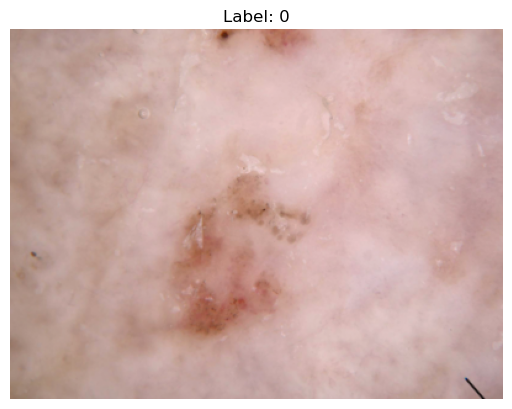

In [7]:

# Fetch one batch from the test_dataloader
_, _, test_dataloader = transform_images((300,400),(300,400))
for images, labels in test_dataloader:
    break

# Unnormalize the image data for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images.numpy().transpose((0, 2, 3, 1))
images = std * images + mean
images = np.clip(images, 0, 1)

# Display the image
plt.imshow(images[0])
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


In [8]:
logger = InMemoryLogger()
train_dataloader, valid_dataloader, test_dataloader=transform_images((300,400),(300,400))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomeModel143K(composer.models.ComposerClassifier):
    def __init__(self, num_classes: int):
        super(CustomeModel143K, self).__init__(
            nn.Sequential(
                ################################## 1 ST CONVOLUTIONAL BLOCK #####################################  
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.Dropout(0.06),
                nn.MaxPool2d(2, 2),  # in 128, out 128

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Dropout(0.07),
                nn.MaxPool2d(2, 2),  # in 64, out 64

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.Dropout(0.07),
                nn.MaxPool2d(2, 2),  # in 32, out 32

                nn.Conv2d(in_channels=64, out_channels=120, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(120),

                nn.AvgPool2d(kernel_size=32),  # 1x1/128
                nn.Flatten(),
                nn.Linear(120, num_classes)  # Output layer with 7 classes
            ),
            num_classes=num_classes
        )


num_classes = 7  # Number of classes in dataset
my_model = CustomeModel143K(num_classes=num_classes).to('cuda')

input_size = (1, 3, 300, 400)  # Batch size, channels, height, width
summary(my_model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 300, 400]             448
              ReLU-2         [-1, 16, 300, 400]               0
       BatchNorm2d-3         [-1, 16, 300, 400]              32
            Conv2d-4         [-1, 16, 300, 400]           2,320
              ReLU-5         [-1, 16, 300, 400]               0
       BatchNorm2d-6         [-1, 16, 300, 400]              32
           Dropout-7         [-1, 16, 300, 400]               0
         MaxPool2d-8         [-1, 16, 150, 200]               0
            Conv2d-9         [-1, 32, 150, 200]           4,640
             ReLU-10         [-1, 32, 150, 200]               0
      BatchNorm2d-11         [-1, 32, 150, 200]              64
           Conv2d-12         [-1, 32, 150, 200]           9,248
             ReLU-13         [-1, 32, 150, 200]               0
      BatchNorm2d-14         [-1, 32, 1

In [13]:
customModel143kBP = CustomeModel143K(num_classes=7)
algorithms, optimizer=requirementsForModelTraining(customModel143kBP)
logger = InMemoryLogger()
trainer = Trainer(
    model=customModel143kBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='30ep',
    algorithms=algorithms,
    loggers=logger,
    save_folder="checkpoints",
    save_filename="cmbp{epoch}.pt",
    save_interval="2ep",
)

In [14]:
start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 0
blurpool/num_blurpool_layers: 3
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 1858387026

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  15:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  15:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  16:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  16:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  17:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  17:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  18:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  18:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  19:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  19:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  20:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  20:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  21:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  21:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  22:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  22:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  23:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  23:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  24:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  24:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  25:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  25:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  26:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  26:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  27:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  27:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  28:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  28:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  29:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  29:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 10232.0121 seconds to train


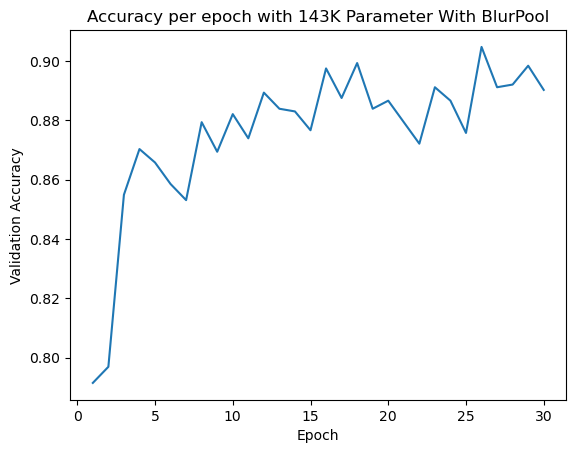

In [16]:
timeseries_raw = logger.get_timeseries("metrics/eval/MulticlassAccuracy")
plt.plot(timeseries_raw['epoch'], timeseries_raw["metrics/eval/MulticlassAccuracy"])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy per epoch with 143K Parameter With BlurPool")
plt.show()

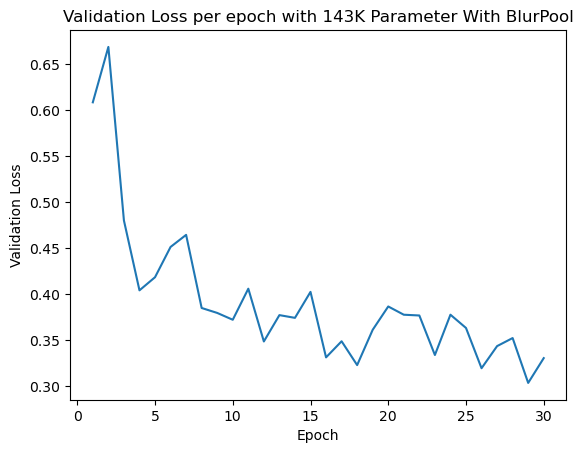

In [17]:
loss = logger.get_timeseries("metrics/eval/CrossEntropy")
plt.plot(loss['epoch'], loss["metrics/eval/CrossEntropy"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per epoch with 143K Parameter With BlurPool")
plt.show()

In [20]:
logged_data = trainer.logger.destinations[0].data

In [ ]:
logged_data

In [47]:
timeseries_train = logger.get_timeseries("metrics/train/MulticlassAccuracy")
len(timeseries_train["metrics/train/MulticlassAccuracy"])

19450

In [22]:
total_layers = sum(1 for _ in customModel143kBP.modules())
total_layers

36

In [19]:
print(trainer.state.train_metrics)
print(trainer.state.eval_metrics)

{'MulticlassAccuracy': MulticlassAccuracy()}
{'eval': {'CrossEntropy': CrossEntropy(), 'MulticlassAccuracy': MulticlassAccuracy()}}


In [ ]:
start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")